In [ ]:
# setup:

! [ -d ~/git_repos ] || mkdir ~/git_repos
! pushd ~/git_repos; [ ! -d pointCollection ] && git clone https://github.com/SmithB/pointCollection.git


# Install pointCollection in the current Jupyter kernel
import sys
! source activate notebook; pushd ~/git_repos/pointCollection; {sys.executable} -m pip install -e . &> /dev/null

# after this, you'll need to change to another kernel, then back to this one for the changes to take effect.


In [2]:
# imports

%load_ext autoreload
%autoreload 2
import glob
import pointCollection as pc
import os
import matplotlib.pyplot as plt
import re
%matplotlib widget
import numpy as np
from sliderule import sliderule, icesat2, earthdata, h5
import geopandas as gpd
import shapely
sliderule.init("slideruleearth.io")


Client (version (4, 5, 3)) is out of date with the server (version (4, 6, 2))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


False

In [3]:
# look in the Nordenskjold output.  This will show what cycles are available:
! h5ls Nordenskjold_binned_photon_stats.h5
# this gives a list of cycles

cycle_10                 Group
cycle_11                 Group
cycle_12                 Group
cycle_13                 Group
cycle_14                 Group
cycle_15                 Group
cycle_16                 Group
cycle_17                 Group
cycle_18                 Group
cycle_19                 Group
cycle_2                  Group
cycle_20                 Group
cycle_21                 Group
cycle_22                 Group
cycle_3                  Group
cycle_4                  Group
cycle_5                  Group
cycle_6                  Group
cycle_7                  Group
cycle_8                  Group
cycle_9                  Group


In [4]:
# this will show the tracks and pairs within the cycle
! h5ls Nordenskjold_binned_photon_stats.h5/cycle_10


rgt1261_p2_strong        Group
rgt1329_p1_strong        Group
rgt1329_p1_weak          Group
rgt1329_p2_strong        Group
rgt1329_p2_weak          Group
rgt1329_p3_strong        Group
rgt1329_p3_weak          Group
rgt316_p2_strong         Group
rgt316_p2_weak           Group
rgt316_p3_strong         Group
rgt316_p3_weak           Group
rgt377_p1_strong         Group
rgt377_p1_weak           Group
rgt377_p2_strong         Group
rgt377_p2_weak           Group
rgt384_p1_strong         Group
rgt384_p1_weak           Group
rgt384_p2_strong         Group
rgt384_p2_weak           Group
rgt384_p3_strong         Group
rgt384_p3_weak           Group
rgt819_p1_strong         Group
rgt819_p1_weak           Group
rgt819_p2_strong         Group
rgt819_p2_weak           Group
rgt819_p3_strong         Group
rgt887_p2_strong         Group
rgt887_p2_weak           Group
rgt887_p3_strong         Group
rgt887_p3_weak           Group


In [5]:
# read a beam-pair group:

cycle=3
rgt = 1268
pair = 1
spot=2*pair-1
D=pc.data().from_h5('Nordenskjold_binned_photon_stats.h5', group=f'cycle_{cycle}/rgt{rgt}_p{pair}_strong')

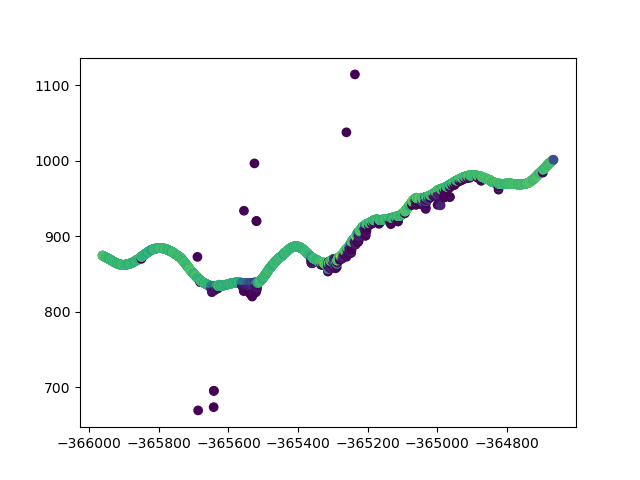

In [6]:
# make a scatter plot of elevation as a function of x coordinate, color coded by the number of photons:
plt.figure()
plt.scatter(D.x, D.h, c=D.N)

In [7]:
# zoom in on a small area of the plot, and run this cell:

# capture the points within Dsub that fall within the axes:
Dsub=D[pc.in_axes([D.x, D.h], ax=plt.gca())]
Dsub

[(-365067.43371955294, -364998.6449600851), (925.3451639095599, 957.5786665969721)]


<class 'pointCollection.data.data'> with shape (197,),
with fields:
['N', 'dh', 'h', 'x', 'x_atc', 'y']

In [8]:
# get the photons corresponding to the data in the axes:

Dsub.get_latlon(EPSG=3413)

bds=[ np.array([np.min(Dsub.longitude), np.max(Dsub.longitude)])+0*np.array([-0.01, 0.01]), 
     np.array([np.min(Dsub.latitude), np.max(Dsub.latitude)])+0*np.array([-0.1, 0.1])]

poly=[{'lat':j, 'lon':k} for j, k in zip(bds[1][[0, 1, 1, 0, 0]], bds[0][[0, 0, 1, 1, 0]])]

params = {
        # processing parameters
        "srt": icesat2.SRT_LAND_ICE,
        "len": 20,
        # classification and checks
        # still return photon segments that fail checks
        "pass_invalid": True, 
        # all photons
        "cnf": 0, 
        "yapc": dict(knn=0, win_h=3, win_x=5.5, min_ph=4, score=0),
        "poly":poly, 
        "rgt":rgt,
        "cycle":cycle,
        "track":pair,
        }
gdf_03 = icesat2.atl03sp(params).to_crs(3413)
gdf_03 = gdf_03[gdf_03.spot==spot]

Using simplified polygon (for CMR request only!), 5 points using tolerance of 0.01


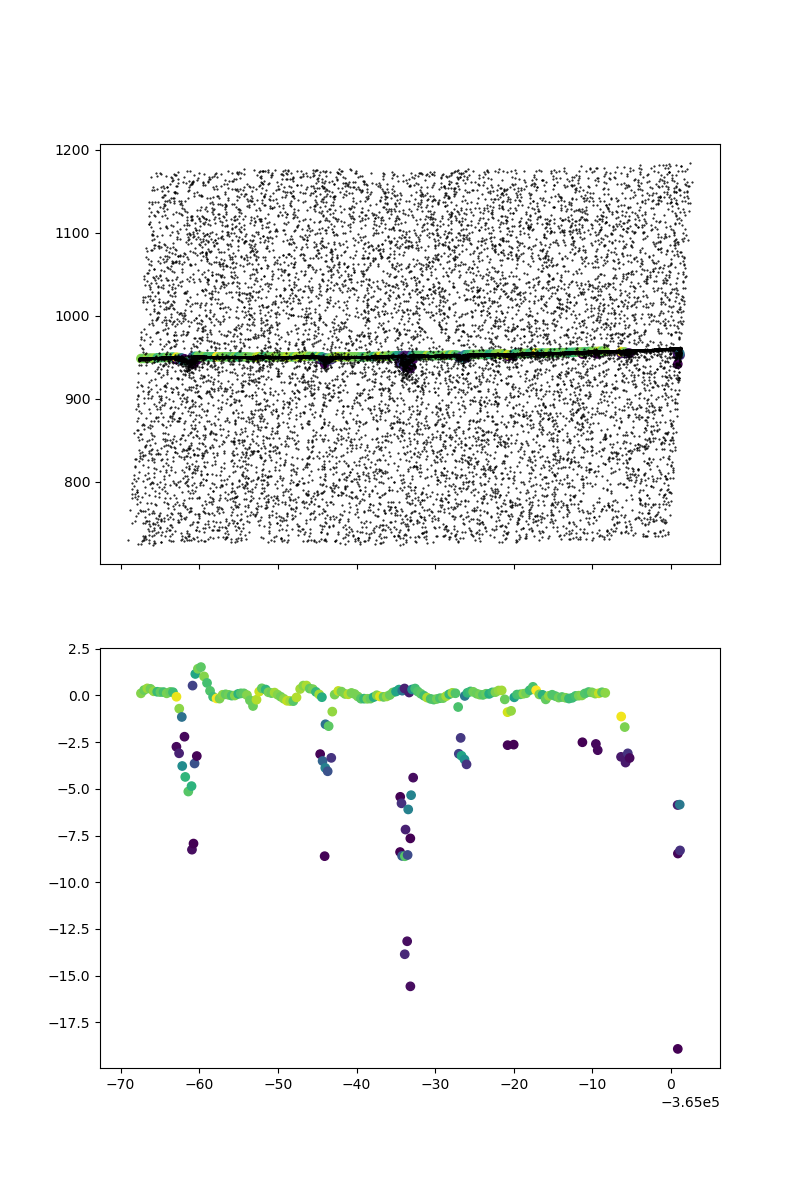

In [9]:
#plot the results:
# Top: crevasse-finder output with photons

hf, hax=plt.subplots(2, 1, sharex=True, figsize=[8, 12])
plt.sca(hax[0])
plt.plot(gdf_03.geometry.x, gdf_03.height,'k.', markersize=1, alpha=1)
plt.scatter(Dsub.x, Dsub.h, c=Dsub.N)

# Bottom: elevation of photons bins relative to the 80-m-resolution surface
plt.sca(hax[1])
plt.scatter(Dsub.x, Dsub.dh, c=Dsub.N)


# More tricks to establish the location of data points

In [38]:
# write the track to a geojson file:
uxy=pc.unique_by_rows(np.c_[D.x, D.y])
temp=gpd.GeoDataFrame(geometry=[shapely.MultiPoint(np.c_[uxy])]).set_crs(3413)
temp.to_file(f'cycle{cycle}_rgt{rgt}_pair{pair}_spot{spot}.geojson')

In [20]:
# Extract the min and max xy values for the points in the zoomed_axes
Dsub1=D[pc.in_axes([D.x, D.h], ax=hax[0])]

print(f'x:{np.min(Dsub1.x):10.0f}, {np.max(Dsub1.x):10.0f}')
print(f'y:{np.min(Dsub1.y):10.0f}, {np.max(Dsub1.y):10.0f}')


[(-365064.0575572535, -365057.2388404422), (936.8566682154857, 955.8610008842832)]
x:   -365064,    -365057
y:  -1456253,   -1456175


In [40]:
# write the point locations from the zoomed axes to a geojson file:
temp=gpd.GeoDataFrame(geometry=[shapely.MultiPoint(np.c_[Dsub1.x, Dsub1.y])]).set_crs(3413)
temp.to_file(f'cycle{cycle}_rgt{rgt}_pair{pair}_spot{spot}_zoomed.geojson')

In [ ]:
# NOTE: you don't have to generate a new filename every time you save a zoomed location- you could just save to a generic file called 'zoom.geojson'
